# Prokrustes-Analyse 

In [99]:
import numpy as np
import pandas as pd
import os

# Parameter
persons = ["AEN262", "DMN261", "JKN261", "MAN262", "MUN261", "NSN261"] #"AEN262", "DMN261", "JKN261", "MAN262", "MUN261", "NSN261"
trials_v1 = [ '01_step', '02_step', '05_squat', '06_squat', '09_ebs', '10_ebs','13_tubes', '14_tubes', '17_sprint', '18_sprint', '21_torso', '22_torso'] #'01_step', '02_step', '05_squat', '06_squat', '09_ebs', '10_ebs', '13_tubes', '14_tubes', '17_sprint', '18_sprint', '21_torso', '22_torso'
trials_v2 = ['01_squat', '02_squat', '05_torso', '06_torso', '09_ebs', '10_ebs', '13_step', '14_step', '17_tubes', '18_tubes', '21_sprint', '22_sprint'] #'01_squat', '02_squat', '05_torso', '06_torso', '09_ebs', '10_ebs', '13_step', '14_step', '17_tubes', '18_tubes', '21_sprint', '22_sprint'

person_to_trials = {
    "AEN262": trials_v2,
    "DMN261": trials_v2, 
    "MAN262": trials_v1,
    "MUN261": trials_v1,
    "NSN261": trials_v2,
    "JKN261": trials_v1,
}

start_frame = 250
end_frame = 1000

cam = 6

# Funktion: Dateipfade erstellen
def generate_file_paths(person, trial):
    vicon_path = f'E:/Datenerhebung MA/Vicon_csv/mittelwert/{person}/30fps/{trial}_mittelwert_30fps.csv'
    poseformer_path = f'E:/Datenerhebung MA/PoseFormerV2 Daten/{person}/Cam{cam}_hoch/{trial}_{cam}_hoch/pose3D_keypoints/combined/combined_keypoints.csv'
    return vicon_path, poseformer_path

# Funktion: Procrustes-Analyse
def procrustes_analysis(A, B):
    A_centroid, B_centroid = np.mean(A, axis=0), np.mean(B, axis=0)
    A_centered, B_centered = A - A_centroid, B - B_centroid
    A_scale = np.sqrt(np.sum(A_centered**2) / A_centered.shape[0])
    B_scale = np.sqrt(np.sum(B_centered**2) / B_centered.shape[0])
    A_normalized, B_normalized = A_centered / A_scale, B_centered / B_scale

    H = B_normalized.T @ A_normalized
    U, _, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    A_transformed = A_normalized @ R

    marker_errors_in_mm = np.linalg.norm((A_transformed - B_normalized), axis=1) * B_scale
    mpjpe_in_mm = np.mean(marker_errors_in_mm)
    return mpjpe_in_mm, marker_errors_in_mm

# Hauptprozess
for person in persons:
    for trial in person_to_trials[person]:
        print(f"Processing {person} - {trial}...")

        # Lade Dateien
        vicon_file, poseformer_file = generate_file_paths(person, trial)
        if not os.path.exists(vicon_file) or not os.path.exists(poseformer_file):
            print(f"File not found: {vicon_file} or {poseformer_file}")
            continue

        vicon_data = pd.read_csv(vicon_file)
        poseformer_data = pd.read_csv(poseformer_file, header=None)
        
        # Entfernen der HIPMIDDLE
        excluded_columns_vicon = [col for col in vicon_data.columns if any(marker in col for marker in ['HIPMIDDLE'])]
        excluded_columns_indices = [vicon_data.columns.get_loc(col) for col in excluded_columns_vicon]
        vicon_data_cleaned = vicon_data.drop(columns=excluded_columns_vicon)
        poseformer_data_cleaned = poseformer_data.drop(columns=poseformer_data.columns[excluded_columns_indices])
       
    
        
        # Extrahieren der Marker-Namen
        marker_names = [col.split(':')[0] for col in vicon_data_cleaned.columns if ':X' in col]
        num_frames = min(len(vicon_data_cleaned), len(poseformer_data_cleaned))
 
        results = []
        for i in range(start_frame, min(end_frame + 1, num_frames + 1)):
            vicon_frame = vicon_data_cleaned.iloc[i - 1, 1:].values.reshape(-1, 3)
            poseformer_frame = poseformer_data_cleaned.iloc[i - 1, 1:].values.reshape(-1, 3)
            if not (np.isnan(vicon_frame).any() or np.isnan(poseformer_frame).any()):
                try:
                    mpjpe, marker_errors = procrustes_analysis(poseformer_frame, vicon_frame)
                    results.append([i, mpjpe] + marker_errors.tolist())
                except np.linalg.LinAlgError:
                    results.append([i, np.nan] + [np.nan] * len(marker_names))
            else:
                results.append([i, np.nan] + [np.nan] * len(marker_names))

        # Ergebnisse speichern
        columns = ['Frame', 'MPJPE (mm)'] + [f'{marker} Error (mm)' for marker in marker_names]
        result_df = pd.DataFrame(results, columns=columns)

        # Speichern der Ergebnisse
        output_file = f'E:/Datenerhebung MA/MPJPE/Poseformer/Cam{cam}/{person}_{trial}_MPJPE.csv'
        result_df.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}.")

Processing AEN262 - 01_squat...
File not found: E:/Datenerhebung MA/Vicon_csv/mittelwert/AEN262/30fps/01_squat_mittelwert_30fps.csv or E:/Datenerhebung MA/PoseFormerV2 Daten/AEN262/Cam6_hoch/01_squat_6_hoch/pose3D_keypoints/combined/combined_keypoints.csv
Processing AEN262 - 02_squat...
File not found: E:/Datenerhebung MA/Vicon_csv/mittelwert/AEN262/30fps/02_squat_mittelwert_30fps.csv or E:/Datenerhebung MA/PoseFormerV2 Daten/AEN262/Cam6_hoch/02_squat_6_hoch/pose3D_keypoints/combined/combined_keypoints.csv
Processing AEN262 - 05_torso...
File not found: E:/Datenerhebung MA/Vicon_csv/mittelwert/AEN262/30fps/05_torso_mittelwert_30fps.csv or E:/Datenerhebung MA/PoseFormerV2 Daten/AEN262/Cam6_hoch/05_torso_6_hoch/pose3D_keypoints/combined/combined_keypoints.csv
Processing AEN262 - 06_torso...
File not found: E:/Datenerhebung MA/Vicon_csv/mittelwert/AEN262/30fps/06_torso_mittelwert_30fps.csv or E:/Datenerhebung MA/PoseFormerV2 Daten/AEN262/Cam6_hoch/06_torso_6_hoch/pose3D_keypoints/combined

## Alle Dateien von einer Cam (ein Ordner mit allen Trials aller VPs) zusammenfügen, um generellen Mittelwert zu bekommen

In [100]:
import os
import pandas as pd

# Pfad zu dem Ordner, der die CSV-Dateien enthält
#folder_path = f"E:/Datenerhebung MA/MPJPE/MediaPipe/Complexity2/Cam4"
folder_path = f"E:/Datenerhebung MA/MPJPE/Poseformer/Cam6"

# Liste aller Dateien im Ordner mit der Endung '.csv'
all_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')  and f != "combined_data.csv"]

# Initialisiere einen leeren DataFrame für die kombinierten Daten
combined_data = pd.DataFrame()

# Iteriere über alle Dateien und füge sie zum kombinierten DataFrame hinzu
for file in all_files:
    file_path = os.path.join(folder_path, file)
    try:
        # Lade die Datei
        df = pd.read_csv(file_path)
        
        # Optionale Spalte hinzufügen, um die Quelle zu markieren
        df['Source_File'] = file
        
        # Kombiniere die Daten
        combined_data = pd.concat([combined_data, df], ignore_index=True)
    except Exception as e:
        print(f"Fehler beim Verarbeiten der Datei {file}: {e}")

# Speichere die kombinierten Daten in einer neuen CSV-Datei
#output_file = os.path.join(folder_path, f"E:/Datenerhebung MA/MPJPE/MediaPipe/Complexity2/Cam4/combined_data.csv")
output_file = os.path.join(folder_path, f"E:/Datenerhebung MA/MPJPE/Poseformer/Cam6/combined_data.csv")
combined_data.to_csv(output_file, index=False)

print(f"Alle Dateien wurden erfolgreich kombiniert und gespeichert in: {output_file}")


Alle Dateien wurden erfolgreich kombiniert und gespeichert in: E:/Datenerhebung MA/MPJPE/Poseformer/Cam6/combined_data.csv


##löscht ausmgewählte Marker

In [2]:
# Importieren der notwendigen Bibliotheken
import pandas as pd

# CSV-Datei laden (ersetze 'file_path' durch den tatsächlichen Dateipfad)
file_path = r'E:\Datenerhebung MA\MPJPE\Poseformer\Cam3\AEN262_01_squat_MPJPE.csv'  # Ursprüngliche Datei
output_path = r'E:\Datenerhebung MA\MPJPE\no_hip_wrist\Poseformer\Cam3\AEN262_01_squat_MPJPE.csv'  # Speicherort für die modifizierte Datei
data = pd.read_csv(file_path)

# Liste der zu löschenden Spalten definieren
columns_to_delete = [
    'RWRIST Error (mm)', 
    'LWRIST Error (mm)' ,
    'HIPMIDDLE Error (mm)', 
    'MPJPE (mm)', # Beispielspalten, passe sie an deine Anforderungen an
]


# Prüfen, ob die Spalten in den Daten vorhanden sind
columns_to_delete = [col for col in columns_to_delete if col in data.columns]

# Spalten löschen
data_modified = data.drop(columns=columns_to_delete)

# Neue Spalte "MPJPE(mm)" einfügen, die den Mittelwert aller anderen Spalten (außer "Frame") berechnet
data_modified["MPJPE(mm)"] = data_modified.drop(columns=["Frame"]).mean(axis=1)

# Neue Spalte an die zweite Position verschieben
cols = data_modified.columns.tolist()
cols.insert(1, cols.pop(-1))  # "MPJPE(mm)" an die zweite Stelle verschieben
data_modified = data_modified[cols]

# Modifizierte Daten in eine neue CSV-Datei speichern
data_modified.to_csv(output_path, index=False)

print(f"Die modifizierte Datei wurde erfolgreich unter '{output_path}' gespeichert.")


Die modifizierte Datei wurde erfolgreich unter 'E:\Datenerhebung MA\MPJPE\no_hip_wrist\Poseformer\Cam3\AEN262_01_squat_MPJPE.csv' gespeichert.


# MediaPipe

In [47]:
import numpy as np
import pandas as pd
import os

# Parameter
persons = ["AEN262", "DMN261", "JKN261", "MAN262", "MUN261", "NSN261"]
trials_v1 = [ '01_step', '02_step', '05_squat', '06_squat', '09_ebs', '10_ebs','13_tubes', '14_tubes', '17_sprint', '18_sprint', '21_torso', '22_torso']
trials_v2 = ['01_squat', '02_squat', '05_torso', '06_torso', '09_ebs', '10_ebs', '13_step', '14_step', '17_tubes', '18_tubes', '21_sprint', '22_sprint']

person_to_trials = {
    "AEN262": trials_v2,
    "DMN261": trials_v2, 
    "MAN262": trials_v1,
    "MUN261": trials_v1,
    "NSN261": trials_v2,
    "JKN261": trials_v1,
}

start_frame = 250
end_frame = 1000

complexity = 0
cam = 4
# Funktion: Dateipfade erstellen
def generate_file_paths(person, trial):
    vicon_path = f'E:/Datenerhebung MA/Vicon_csv/mittelwert/{person}/30fps/{trial}_mittelwert_30fps.csv'
    mediapipe_path = f'E:/Datenerhebung MA/MediaPipe/{person}/Cam{cam}_hoch/Complexity{complexity}/formatted/{trial}_{cam}_hoch_comp{complexity}_formatted.csv'
    return vicon_path, mediapipe_path

# Funktion: Procrustes-Analyse
def procrustes_analysis(A, B):
    A_centroid, B_centroid = np.mean(A, axis=0), np.mean(B, axis=0)
    A_centered, B_centered = A - A_centroid, B - B_centroid
    A_scale = np.sqrt(np.sum(A_centered**2) / A_centered.shape[0])
    B_scale = np.sqrt(np.sum(B_centered**2) / B_centered.shape[0])
    A_normalized, B_normalized = A_centered / A_scale, B_centered / B_scale

    H = B_normalized.T @ A_normalized
    U, _, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    A_transformed = A_normalized @ R

    marker_errors_in_mm = np.linalg.norm((A_transformed - B_normalized), axis=1) * B_scale
    mpjpe_in_mm = np.mean(marker_errors_in_mm)
    return mpjpe_in_mm, marker_errors_in_mm

# Hauptprozess
for person in persons:
    for trial in person_to_trials[person]:
        try:
            print(f"Processing {person} - {trial}...")

            # Lade Dateien
            vicon_file, mediapipe_file = generate_file_paths(person, trial)
            if not os.path.exists(vicon_file) or not os.path.exists(mediapipe_file):
                raise FileNotFoundError(f"File not found: {vicon_file} or {mediapipe_file}")

            vicon_data = pd.read_csv(vicon_file)
            mediapipe_data = pd.read_csv(mediapipe_file, header=None)

            # Entfernen der HIPMIDDLE
            excluded_columns_vicon = [col for col in vicon_data.columns if any(marker in col for marker in ['HIPMIDDLE'])]
            vicon_data_cleaned = vicon_data.drop(columns=excluded_columns_vicon)
            mediapipe_data_cleaned = mediapipe_data

            # Extrahieren der Marker-Namen
            marker_names = [col.split(':')[0] for col in vicon_data_cleaned.columns if ':X' in col]
            num_frames = min(len(vicon_data_cleaned), len(mediapipe_data_cleaned))

            results = []
            for i in range(start_frame, min(end_frame + 1, num_frames + 1)):
                vicon_frame = vicon_data_cleaned.iloc[i - 1, 1:].values.reshape(-1, 3)
                mediapipe_frame = mediapipe_data_cleaned.iloc[i - 1, 1:].values.reshape(-1, 3)
                if not (np.isnan(vicon_frame).any() or np.isnan(mediapipe_frame).any()):
                    try:
                        mpjpe, marker_errors = procrustes_analysis(mediapipe_frame, vicon_frame)
                        results.append([i, mpjpe] + marker_errors.tolist())
                    except np.linalg.LinAlgError:
                        results.append([i, np.nan] + [np.nan] * len(marker_names))
                else:
                    results.append([i, np.nan] + [np.nan] * len(marker_names))

            # Ergebnisse speichern
            columns = ['Frame', 'MPJPE (mm)'] + [f'{marker} Error (mm)' for marker in marker_names]
            result_df = pd.DataFrame(results, columns=columns)

            # Speichern der Ergebnisse
            output_file = f'E:/Datenerhebung MA/MPJPE/Mediapipe/Complexity{complexity}/Cam{cam}/{person}_{trial}_MPJPE.csv'
            result_df.to_csv(output_file, index=False)
            print(f"Results saved to {output_file}.")

        except Exception as e:
            print(f"Error processing {person} - {trial}: {e}")


Processing AEN262 - 01_squat...
Error processing AEN262 - 01_squat: File not found: E:/Datenerhebung MA/Vicon_csv/mittelwert/AEN262/30fps/01_squat_mittelwert_30fps.csv or E:/Datenerhebung MA/MediaPipe/AEN262/Cam6_hoch/Complexity2/formatted/01_squat_6_hoch_comp2_formatted.csv
Processing AEN262 - 02_squat...
Error processing AEN262 - 02_squat: File not found: E:/Datenerhebung MA/Vicon_csv/mittelwert/AEN262/30fps/02_squat_mittelwert_30fps.csv or E:/Datenerhebung MA/MediaPipe/AEN262/Cam6_hoch/Complexity2/formatted/02_squat_6_hoch_comp2_formatted.csv
Processing AEN262 - 05_torso...
Error processing AEN262 - 05_torso: File not found: E:/Datenerhebung MA/Vicon_csv/mittelwert/AEN262/30fps/05_torso_mittelwert_30fps.csv or E:/Datenerhebung MA/MediaPipe/AEN262/Cam6_hoch/Complexity2/formatted/05_torso_6_hoch_comp2_formatted.csv
Processing AEN262 - 06_torso...
Error processing AEN262 - 06_torso: File not found: E:/Datenerhebung MA/Vicon_csv/mittelwert/AEN262/30fps/06_torso_mittelwert_30fps.csv or E

# HEATMAP

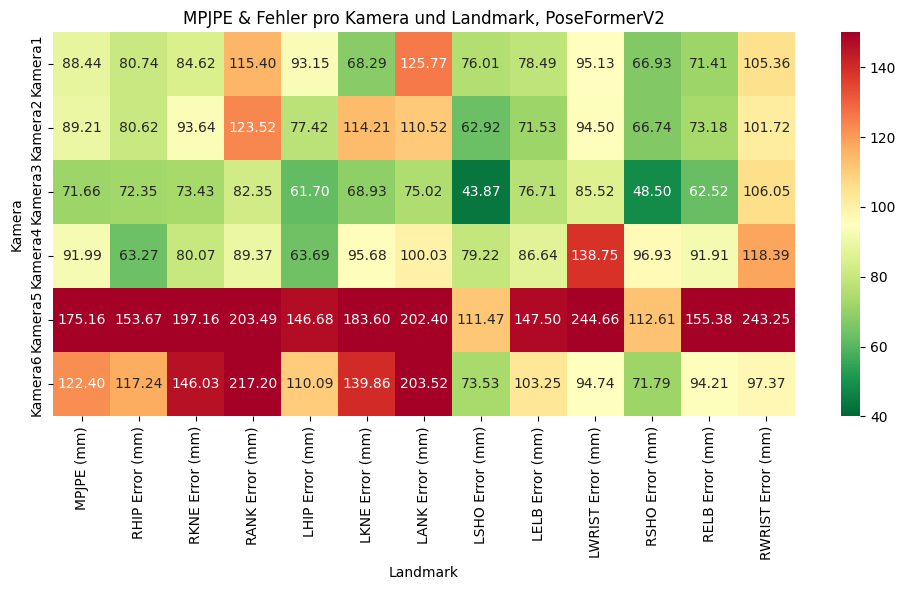

In [101]:
# Erforderliche Bibliotheken importieren
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Die Dateien laden
file_cam1 = 'E:/Datenerhebung MA/MPJPE/Poseformer/Cam1/combined_data_cam1.csv'
file_cam2 = 'E:/Datenerhebung MA/MPJPE/Poseformer/Cam2_hoch/combined_data_cam2.csv'
file_cam3 = 'E:/Datenerhebung MA/MPJPE/Poseformer/Cam3/combined_data.csv'
file_cam4 = 'E:/Datenerhebung MA/MPJPE/Poseformer/Cam4/combined_data.csv'
file_cam5 = 'E:/Datenerhebung MA/MPJPE/Poseformer/Cam5/combined_data.csv'
file_cam6 = 'E:/Datenerhebung MA/MPJPE/Poseformer/Cam6/combined_data.csv'

data_cam1 = pd.read_csv(file_cam1)
data_cam2 = pd.read_csv(file_cam2)
data_cam3 = pd.read_csv(file_cam3)
data_cam4 = pd.read_csv(file_cam4)
data_cam5 = pd.read_csv(file_cam5)
data_cam6 = pd.read_csv(file_cam6)

# Kameranamen zu den jeweiligen Datensätzen hinzufügen
data_cam1['Camera'] = 'Kamera1'
data_cam2['Camera'] = 'Kamera2' 
data_cam3['Camera'] = 'Kamera3' 
data_cam4['Camera'] = 'Kamera4'
data_cam5['Camera'] = 'Kamera5' 
data_cam6['Camera'] = 'Kamera6' 


# Datensätze kombinieren
combined_data = pd.concat([data_cam1, data_cam2, data_cam3, data_cam4, data_cam5, data_cam6], ignore_index=True)

# Spalten, die ignoriert werden sollen, entfernen
combined_data = combined_data.drop(columns=['Frame', 'Source_File'])

# Berechnung des Mittelwerts pro Kamera und Fehlerkategorie
heatmap_data = combined_data.groupby('Camera').mean().filter(
    regex='Error|MPJPE', axis=1
)
vmin, vmax = 40, 150
# Erstellen der Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt=".2f", 
    cmap="RdYlGn_r", 
    vmin=vmin, 
    vmax=vmax
)


# Achsentitel und Diagrammtitel
plt.title("MPJPE & Fehler pro Kamera und Landmark, PoseFormerV2")
plt.xlabel("Landmark")
plt.ylabel("Kamera")

# Heatmap anzeigen
plt.tight_layout()
plt.show()


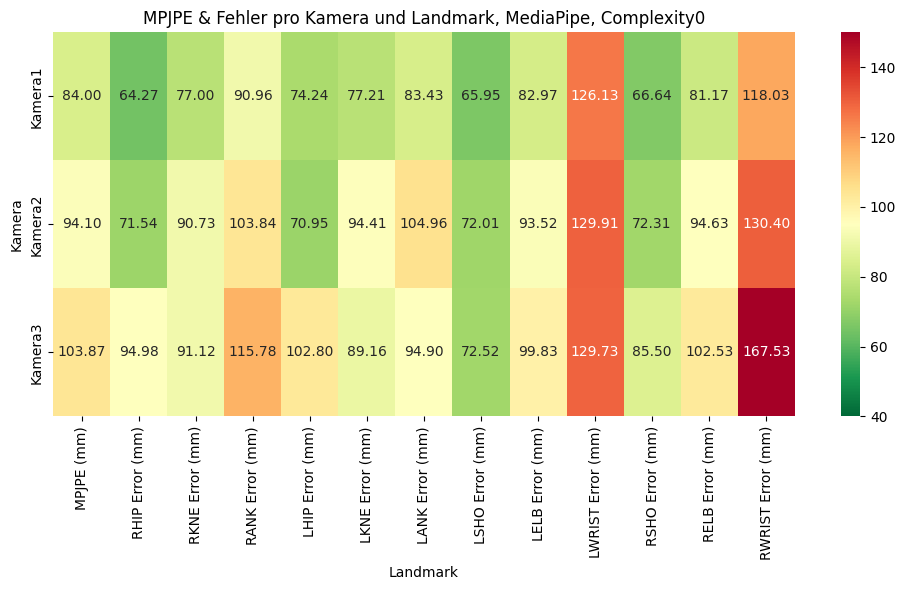

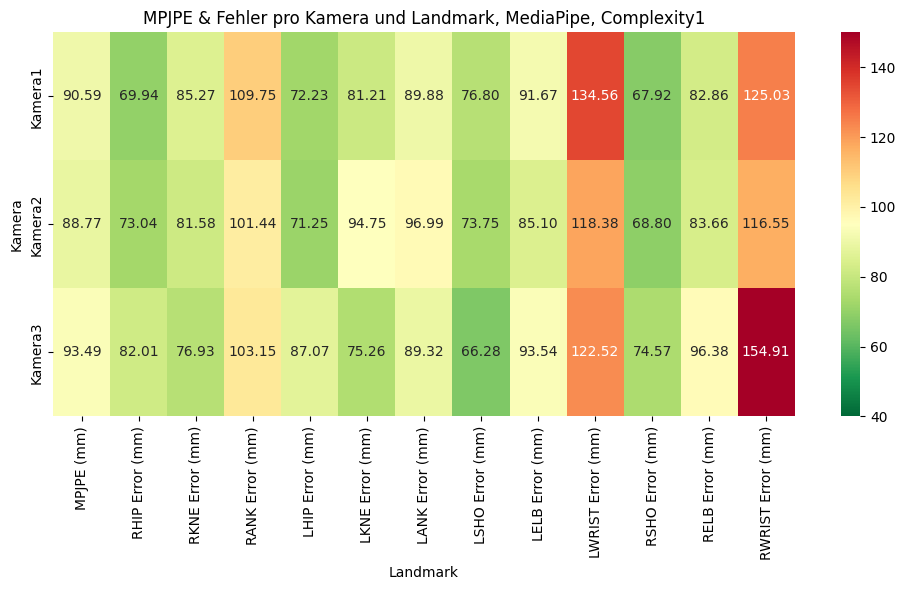

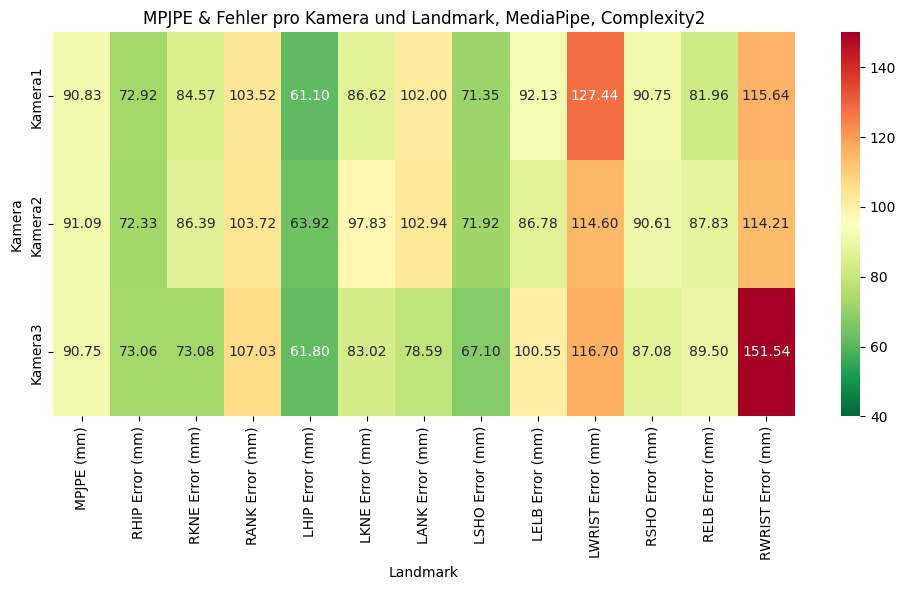

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def generate_heatmap(complexity, base_path, vmin=None, vmax=None):
    """
    Erstellt eine Heatmap basierend auf den Eingabedateien einer bestimmten Complexity-Stufe.

    Parameters:
        complexity (int): Die Complexity-Stufe (0, 1, 2, ...).
        base_path (str): Der Basis-Pfad zu den Dateien.
        vmin (float, optional): Minimalwert der Farbskala.
        vmax (float, optional): Maximalwert der Farbskala.
    """
    # Dateienpfade erstellen
    file_cam1 = f'{base_path}/Complexity{complexity}/Cam1/combined_data.csv'
    file_cam2 = f'{base_path}/Complexity{complexity}/Cam2/combined_data.csv'
    file_cam3 = f'{base_path}/Complexity{complexity}/Cam3/combined_data_ohneMUN.csv'
    file_cam4 = f'{base_path}/Complexity{complexity}/Cam4/combined_data.csv'
    file_cam5 = f'{base_path}/Complexity{complexity}/Cam5/combined_data.csv'
    file_cam6 = f'{base_path}/Complexity{complexity}/Cam6/combined_data.csv'

    # Dateien laden
    data_cam1 = pd.read_csv(file_cam1)
    data_cam2 = pd.read_csv(file_cam2)
    data_cam3 = pd.read_csv(file_cam3)
    data_cam4 = pd.read_csv(file_cam4)
    data_cam5 = pd.read_csv(file_cam5)
    data_cam6 = pd.read_csv(file_cam6)

    # Kameranamen hinzufügen
    data_cam1['Camera'] = 'Kamera1'
    data_cam2['Camera'] = 'Kamera2'
    data_cam3['Camera'] = 'Kamera3'
    #data_cam4['Camera'] = 'Kamera4'
    #data_cam5['Camera'] = 'Kamera5'
    #data_cam6['Camera'] = 'Kamera6'

    # Datensätze kombinieren
    combined_data = pd.concat([data_cam1, data_cam2, data_cam3], ignore_index=True)
    #combined_data = pd.concat([data_cam1, data_cam2, data_cam3, data_cam4, data_cam5, data_cam6], ignore_index=True)

    # Nicht benötigte Spalten entfernen
    combined_data = combined_data.drop(columns=['Frame', 'Source_File',])

    # Mittelwerte berechnen
    heatmap_data = combined_data.groupby('Camera').mean().filter(
        regex='Error|MPJPE', axis=1
    )

    # Heatmap erstellen
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        heatmap_data, 
        annot=True, 
        fmt=".2f", 
        cmap="RdYlGn_r", 
        vmin=vmin, 
        vmax=vmax  # Fixierte Farbskala
    )

    # Achsentitel und Diagrammtitel
    plt.title(f"MPJPE & Fehler pro Kamera und Landmark, MediaPipe, Complexity{complexity}")
    plt.xlabel("Landmark")
    plt.ylabel("Kamera")

    # Heatmap anzeigen
    plt.tight_layout()
    plt.show()

# Hauptprogramm
base_path = 'E:/Datenerhebung MA/MPJPE/Mediapipe'

# Bestimme den Bereich der Farbskala (z.B. durch Analyse aller Daten)
vmin, vmax = 40, 150  # Beispielwerte; passe sie je nach Datenbereich an

# Heatmaps für verschiedene Complexity-Stufen generieren
for complexity in range(0,3):  # Falls du mehr als 3 Complexity-Stufen hast, passe den Bereich an
    generate_heatmap(complexity, base_path, vmin=vmin, vmax=vmax)


## einzelne Fehler plotten 

PoseFormerV2

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Parameter
persons = ["AEN262"] #"AEN262", "DMN261", "JKN261", "MAN262", "MUN261", "NSN261"
trials_v1 = [ '05_squat', '06_squat']  ## '01_step', '02_step', '05_squat', '06_squat', '09_ebs', '10_ebs','13_tubes', '14_tubes', '17_sprint', '18_sprint', '21_torso', '22_torso'
trials_v2 = ['09_ebs', '01_squat', "02_squat"]

person_to_trials = {
    "AEN262": trials_v2,
    "DMN261": trials_v2, 
    "MAN262": trials_v1,
    "MUN261": trials_v1,
    "NSN261": trials_v2,
    "JKN261": trials_v1,
}

start_frame = 500
end_frame = 2000

# Funktion: Dateipfade erstellen
def generate_file_paths(person, trial):
    vicon_path = f'E:/Datenerhebung MA/Vicon_csv/mittelwert/{person}/60fps/{trial}_mittelwert_60fps.csv'
    poseformer_path = f'E:/Datenerhebung MA/PoseFormerV2 Daten/{person}/Cam1/{trial}_1/pose3D_keypoints/combined/combined_keypoints.csv'
    return vicon_path, poseformer_path

# Funktion: Procrustes-Analyse
def procrustes_analysis(A, B, offset):
    A_centroid, B_centroid = np.mean(A, axis=0), np.mean(B, axis=0)
    A_centered, B_centered = A - A_centroid, B - B_centroid
    A_scale = np.sqrt(np.sum(A_centered**2) / A_centered.shape[0])
    B_scale = np.sqrt(np.sum(B_centered**2) / B_centered.shape[0])
    A_normalized, B_normalized = A_centered / A_scale, B_centered / B_scale

    H = B_normalized.T @ A_normalized
    U, _, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    A_transformed = A_normalized @ R

    diff = A_transformed - B_normalized
    marker_errors_in_mm = np.linalg.norm((A_transformed - B_normalized - offset), axis=1) * B_scale
    mpjpe_in_mm = np.mean(marker_errors_in_mm)
    return mpjpe_in_mm, marker_errors_in_mm, diff

# Hauptprozess
for person in persons:
    for trial in person_to_trials[person]:
        print(f"Processing {person} - {trial}...")

        # Lade Dateien
        vicon_file, poseformer_file = generate_file_paths(person, trial)
        if not os.path.exists(vicon_file) or not os.path.exists(poseformer_file):
            print(f"File not found: {vicon_file} or {poseformer_file}")
            continue

        vicon_data = pd.read_csv(vicon_file)
        poseformer_data = pd.read_csv(poseformer_file, header=None)
        
        # Entfernen der HIPMIDDLE
        excluded_columns_vicon = [col for col in vicon_data.columns if any(marker in col for marker in ['HIPMIDDLE'])]
        excluded_columns_indices = [vicon_data.columns.get_loc(col) for col in excluded_columns_vicon]
        vicon_data_cleaned = vicon_data.drop(columns=excluded_columns_vicon)
        poseformer_data_cleaned = poseformer_data.drop(columns=poseformer_data.columns[excluded_columns_indices])

        # Extrahieren der Marker-Namen
        marker_names = [col.split(':')[0] for col in vicon_data_cleaned.columns if ':X' in col]
        num_frames = min(len(vicon_data_cleaned), len(poseformer_data_cleaned))

        # Initialisierung des Offsets als numpy-Array
        offset = np.zeros((len(marker_names), 3))

        # Erster Durchlauf: Offset berechnen
        results_first_loop = []
        for i in range(start_frame, min(end_frame + 1, num_frames + 1)):
            vicon_frame = vicon_data_cleaned.iloc[i - 1, 1:].values.reshape(-1, 3)
            poseformer_frame = poseformer_data_cleaned.iloc[i - 1, 1:].values.reshape(-1, 3)
            if not (np.isnan(vicon_frame).any() or np.isnan(poseformer_frame).any()):
                try:
                    mpjpe, marker_errors, diff = procrustes_analysis(poseformer_frame, vicon_frame, np.zeros((len(marker_names), 3)))
                    results_first_loop.append([i, mpjpe] + marker_errors.tolist())
                    offset += diff  # Differenzvektor aufaddieren
                except np.linalg.LinAlgError:
                    results_first_loop.append([i, np.nan] + [np.nan] * len(marker_names))
            else:
                results_first_loop.append([i, np.nan] + [np.nan] * len(marker_names))

        # Durchschnittsoffset berechnen
      
        offset /= (end_frame - start_frame + 1)
        #offset2 = offset

        # Plot nach erstem Durchlauf
        results_first_df = pd.DataFrame(results_first_loop, columns=['Frame', 'MPJPE'] + marker_names)
        rhip_error_column_first = [col for col in results_first_df.columns if 'RELB' in col][0]
        #rkne_error_column_first = [col for col in results_first_df.columns if 'RKNE' in col][0]
        rhip_errors_first = results_first_df[rhip_error_column_first]
       # rkne_errors_first = results_first_df[rkne_error_column_first]

        plt.figure(figsize=(10, 6))
        plt.plot(results_first_df['Frame'], rhip_errors_first, label='RHIP Error', color='green', linewidth=2)
        #plt.plot(results_first_df['Frame'], rkne_errors_first, label='RKNE Error', color='red', linewidth=2)
        plt.title('RHIP & RKNE Error über Frames', fontsize=14)
        plt.xlabel('Frame', fontsize=12)
        plt.ylabel('Error (mm)', fontsize=12)
        plt.ylim(0,200)
        plt.grid(True)
        plt.legend()
        plt.show()

        # Zweiter Durchlauf: Mit berechnetem Offset
        results_second_loop = []
        for i in range(start_frame, min(end_frame + 1, num_frames + 1)):
            vicon_frame = vicon_data_cleaned.iloc[i - 1, 1:].values.reshape(-1, 3)
            poseformer_frame = poseformer_data_cleaned.iloc[i - 1, 1:].values.reshape(-1, 3)
            if not (np.isnan(vicon_frame).any() or np.isnan(poseformer_frame).any()):
                try:
                    mpjpe, marker_errors, diff = procrustes_analysis(poseformer_frame, vicon_frame, offset)
                    results_second_loop.append([i, mpjpe] + marker_errors.tolist())
                except np.linalg.LinAlgError:
                    results_second_loop.append([i, np.nan] + [np.nan] * len(marker_names))
            else:
                results_second_loop.append([i, np.nan] + [np.nan] * len(marker_names))

        # Plot nach zweitem Durchlauf
        #results_second_df = pd.DataFrame(results_second_loop, columns=['Frame', 'MPJPE'] + marker_names)
        #rhip_error_column_second = [col for col in results_second_df.columns if 'RELB' in col][0]
        #rhip_errors_second = results_second_df[rhip_error_column_second]

        #plt.figure(figsize=(10, 6))
        #plt.plot(results_second_df['Frame'], rhip_errors_second, label='RHIP Error (Second Loop)', color='green', linewidth=2)
        #plt.title('RHIP Error über Frames (Korrigiert)', fontsize=14)
        #plt.xlabel('Frame', fontsize=12)
        #plt.ylabel('RHIP Error (mm)', fontsize=12)
        #plt.grid(True)
        #plt.ylim(0,200)
        #plt.legend()
        #plt.show()


MediaPipe

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Parameter
persons = ["AEN262"] #"AEN262", "DMN261", "JKN261", "MAN262", "MUN261", "NSN261"
trials_v1 = ['05_squat', '06_squat'] ##'01_step', '02_step', '05_squat', '06_squat', '09_ebs', '10_ebs','13_tubes', '14_tubes', '17_sprint', '18_sprint', '21_torso', '22_torso''01_step', '02_step', '05_squat', '06_squat', '09_ebs', '10_ebs','13_tubes', '14_tubes', '17_sprint', '18_sprint', '21_torso', '22_torso'
trials_v2 = ['09_ebs','01_squat', "02_squat"]

person_to_trials = {
    "AEN262": trials_v2,
    "DMN261": trials_v2, 
    "MAN262": trials_v1,
    "MUN261": trials_v1,
    "NSN261": trials_v2,
    "JKN261": trials_v1,
}

start_frame = 500
end_frame = 2000

# Funktion: Dateipfade erstellen
def generate_file_paths(person, trial):
    vicon_path = f'E:/Datenerhebung MA/Vicon_csv/mittelwert/{person}/60fps/{trial}_mittelwert_60fps.csv'
    mediapipe_path = f'E:/Datenerhebung MA/MediaPipe/{person}/Cam1/Complexity0/formatted/{trial}_1_comp0_formatted.csv'
    return vicon_path, mediapipe_path

# Funktion: Procrustes-Analyse
def procrustes_analysis(A, B, offset):
    A_centroid, B_centroid = np.mean(A, axis=0), np.mean(B, axis=0)
    A_centered, B_centered = A - A_centroid, B - B_centroid
    A_scale = np.sqrt(np.sum(A_centered**2) / A_centered.shape[0])
    B_scale = np.sqrt(np.sum(B_centered**2) / B_centered.shape[0])
    A_normalized, B_normalized = A_centered / A_scale, B_centered / B_scale

    H = B_normalized.T @ A_normalized
    U, _, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    A_transformed = A_normalized @ R

    diff = A_transformed - B_normalized
    marker_errors_in_mm = np.linalg.norm((A_transformed - B_normalized - offset), axis=1) * B_scale
    mpjpe_in_mm = np.mean(marker_errors_in_mm)
    return mpjpe_in_mm, marker_errors_in_mm, diff

# Hauptprozess
for person in persons:
    for trial in person_to_trials[person]:
        print(f"Processing {person} - {trial}...")

        # Lade Dateien
        vicon_file, mediapipe_file = generate_file_paths(person, trial)
        if not os.path.exists(vicon_file) or not os.path.exists(mediapipe_file):
            print(f"File not found: {vicon_file} or {mediapipe_file}")
            continue

        vicon_data = pd.read_csv(vicon_file)
        mediapipe_data = pd.read_csv(mediapipe_file, header=None)
        
        # Entfernen der HIPMIDDLE
        excluded_columns_vicon = [col for col in vicon_data.columns if any(marker in col for marker in ['HIPMIDDLE'])]
        excluded_columns_indices = [vicon_data.columns.get_loc(col) for col in excluded_columns_vicon]
        vicon_data_cleaned = vicon_data.drop(columns=excluded_columns_vicon)
        mediapipe_data_cleaned = mediapipe_data
       
        # Extrahieren der Marker-Namen
        marker_names = [col.split(':')[0] for col in vicon_data_cleaned.columns if ':X' in col]
        num_frames = min(len(vicon_data_cleaned), len(mediapipe_data_cleaned))

        # Initialisierung des Offsets als numpy-Array
        offset = np.zeros((len(marker_names), 3))

        # Erster Durchlauf: Offset berechnen
        results_first_loop = []
        for i in range(start_frame, min(end_frame + 1, num_frames + 1)):
            vicon_frame = vicon_data_cleaned.iloc[i - 1, 1:].values.reshape(-1, 3)
            mediapipe_frame = mediapipe_data_cleaned.iloc[i - 1, 1:].values.reshape(-1, 3)
            if not (np.isnan(vicon_frame).any() or np.isnan(mediapipe_frame).any()):
                try:
                    mpjpe, marker_errors, diff = procrustes_analysis(mediapipe_frame, vicon_frame, np.zeros((len(marker_names), 3)))
                    results_first_loop.append([i, mpjpe] + marker_errors.tolist())
                    offset += diff  # Differenzvektor aufaddieren
                except np.linalg.LinAlgError:
                    results_first_loop.append([i, np.nan] + [np.nan] * len(marker_names))
            else:
                results_first_loop.append([i, np.nan] + [np.nan] * len(marker_names))

        # Durchschnittsoffset berechnen
      
        offset /= (end_frame - start_frame + 1)
        #offset2 = offset

        # Plot nach erstem Durchlauf
        results_first_df = pd.DataFrame(results_first_loop, columns=['Frame', 'MPJPE'] + marker_names)
        rhip_error_column_first = [col for col in results_first_df.columns if 'ELB' in col][0]
        rhip_errors_first = results_first_df[rhip_error_column_first]

        plt.figure(figsize=(10, 6))
        plt.plot(results_first_df['Frame'], rhip_errors_first, label='RHIP Error (First Loop)', color='green', linewidth=2)
        plt.title('RHIP Error über Frames', fontsize=14)
        plt.xlabel('Frame', fontsize=12)
        plt.ylabel('RHIP Error (mm)', fontsize=12)
        plt.ylim(0,300)
        plt.grid(True)
        plt.legend()
        plt.show()

        # Zweiter Durchlauf: Mit berechnetem Offset
        results_second_loop = []
        for i in range(start_frame, min(end_frame + 1, num_frames + 1)):
            vicon_frame = vicon_data_cleaned.iloc[i - 1, 1:].values.reshape(-1, 3)
            mediapipe_frame = mediapipe_data_cleaned.iloc[i - 1, 1:].values.reshape(-1, 3)
            if not (np.isnan(vicon_frame).any() or np.isnan(mediapipe_frame).any()):
                try:
                    mpjpe, marker_errors, diff = procrustes_analysis(mediapipe_frame, vicon_frame, offset)
                    results_second_loop.append([i, mpjpe] + marker_errors.tolist())
                except np.linalg.LinAlgError:
                    results_second_loop.append([i, np.nan] + [np.nan] * len(marker_names))
            else:
                results_second_loop.append([i, np.nan] + [np.nan] * len(marker_names))

        # Plot nach zweitem Durchlauf
        #results_second_df = pd.DataFrame(results_second_loop, columns=['Frame', 'MPJPE'] + marker_names)
        #rhip_error_column_second = [col for col in results_second_df.columns if 'RELB' in col][0]
        #rhip_errors_second = results_second_df[rhip_error_column_second]

        #plt.figure(figsize=(10, 6))
        #plt.plot(results_second_df['Frame'], rhip_errors_second, label='RHIP Error (Second Loop)', color='blue', linewidth=2)
        #plt.title('RHIP Error über Frames (Korrigiert)', fontsize=14)
        #plt.xlabel('Frame', fontsize=12)
        #plt.ylabel('RHIP Error (mm)', fontsize=12)
        #plt.grid(True)
        #plt.ylim(0,200)
        #plt.legend()
        #plt.show()


## Systematischer Fehler berechnen 

Dafür wird zuerst der Vektor jedes Punkteabstandes berechnet. Für jede Übung wird ein csv erstellt, dass den Vektor jedes Markers speichert für jedes Frame. Danach wird mit der zweiten Zelle die durchschnittlichen Vektoren für jede Übung, sowie deren Betrag berechnet und in einem csv gespeichert. 

In [1]:
import numpy as np
import pandas as pd
import os

# Parameter
cam = ("1")
persons = ["AEN262"] #"AEN262", "DMN261", "JKN261", "MAN262", "MUN261", "NSN261"
trials_v1 = [ '01_step', '02_step', '05_squat', '06_squat', '09_ebs', '10_ebs','13_tubes', '14_tubes', '17_sprint', '18_sprint', '21_torso', '22_torso'] #'01_step', '02_step', '05_squat', '06_squat', '09_ebs', '10_ebs', '13_tubes', '14_tubes', '17_sprint', '18_sprint', '21_torso', '22_torso'
trials_v2 = ['01_squat'] #'01_squat', '02_squat', '05_torso', '06_torso', '09_ebs', '10_ebs', '13_step', '14_step', '17_tubes', '18_tubes', '21_sprint', '22_sprint'

person_to_trials = {
    "AEN262": trials_v2,
    "DMN261": trials_v2, 
    "MAN262": trials_v1,
    "MUN261": trials_v1,
    "NSN261": trials_v2,
    "JKN261": trials_v1,
}

start_frame = 500
end_frame = 2000

# Funktion: Dateipfade erstellen
def generate_file_paths(person, trial):
    vicon_path = f'E:/Datenerhebung MA/Vicon_csv/mittelwert/{person}/60fps/{trial}_mittelwert_60fps.csv'
    poseformer_path = f'E:/Datenerhebung MA/PoseFormerV2 Daten/{person}/Cam{cam}/{trial}_{cam}/pose3D_keypoints/combined/combined_keypoints.csv'
    return vicon_path, poseformer_path

# Funktion: Procrustes-Analyse
def procrustes_analysis(A, B):
    A_centroid, B_centroid = np.mean(A, axis=0), np.mean(B, axis=0)
    A_centered, B_centered = A - A_centroid, B - B_centroid
    A_scale = np.sqrt(np.sum(A_centered**2) / A_centered.shape[0])
    B_scale = np.sqrt(np.sum(B_centered**2) / B_centered.shape[0])
    A_normalized, B_normalized = A_centered / A_scale, B_centered / B_scale

    H = B_normalized.T @ A_normalized
    U, _, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    A_transformed = A_normalized @ R

    
    
    difference_vector = A_transformed - B_normalized
    marker_errors_in_mm = np.linalg.norm((A_transformed - B_normalized), axis=1) * B_scale
    mpjpe_in_mm = np.mean(marker_errors_in_mm)
    return mpjpe_in_mm, marker_errors_in_mm, difference_vector



# Hauptprozess
for person in persons:
    for trial in person_to_trials[person]:
        print(f"Processing {person} - {trial}...")

        # Lade Dateien
        vicon_file, poseformer_file = generate_file_paths(person, trial)
        if not os.path.exists(vicon_file) or not os.path.exists(poseformer_file):
            print(f"File not found: {vicon_file} or {poseformer_file}")
            continue

        vicon_data = pd.read_csv(vicon_file)
        poseformer_data = pd.read_csv(poseformer_file, header=None)
        
        # Entfernen der HIPMIDDLE
        excluded_columns_vicon = [col for col in vicon_data.columns if any(marker in col for marker in ['HIPMIDDLE'])]
        excluded_columns_indices = [vicon_data.columns.get_loc(col) for col in excluded_columns_vicon]
        vicon_data_cleaned = vicon_data.drop(columns=excluded_columns_vicon)
        poseformer_data_cleaned = poseformer_data.drop(columns=poseformer_data.columns[excluded_columns_indices])
        
        # Extrahieren der Marker-Namen
        marker_names = [col.split(':')[0] for col in vicon_data_cleaned.columns if ':X' in col]
        num_frames = min(len(vicon_data_cleaned), len(poseformer_data_cleaned))
 
        results = []
        for i in range(start_frame, min(end_frame + 1, num_frames + 1)):
            vicon_frame = vicon_data_cleaned.iloc[i - 1, 1:].values.reshape(-1, 3)
            poseformer_frame = poseformer_data_cleaned.iloc[i - 1, 1:].values.reshape(-1, 3)
            if not (np.isnan(vicon_frame).any() or np.isnan(poseformer_frame).any()):
                try:
                    mpjpe, marker_errors, difference_vector = procrustes_analysis(poseformer_frame, vicon_frame)
                  
                    # Berechnung des B_scale für das aktuelle Frame
                    B_scale = np.sqrt(np.sum((vicon_frame - np.mean(vicon_frame, axis=0))**2) / vicon_frame.shape[0])

                    # Zeile für das aktuelle Frame
                    row = [i]  # Frame Nummer hinzufügen
                    for j, marker in enumerate(marker_names):
                        # Hole den X, Y, Z Differenzvektor für den Marker
                        row.append(difference_vector[j, 0])  # X
                        row.append(difference_vector[j, 1])  # Y
                        row.append(difference_vector[j, 2])  # Z
                    
                    # Füge den B_scale-Wert für das aktuelle Frame hinzu
                    row.append(B_scale)
                    results.append(row)
                except np.linalg.LinAlgError:
                    # Fehlerfall
                    results.append([i] + [np.nan] * len(marker_names) * 3 + [np.nan])  # 3 für den 3D-Vektor und B_scale
            else:
                # Falls NaN-Werte vorhanden sind
                results.append([i] + [np.nan] * len(marker_names) * 3 + [np.nan])  # 3 für den 3D-Vektor und B_scale

        # Spaltennamen für das CSV definieren
        columns = ['Frame']  # Erste Spalte ist die Frame-Nummer
        for marker in marker_names:
            columns.append(f'{marker} Difference Vector X')
            columns.append(f'{marker} Difference Vector Y')
            columns.append(f'{marker} Difference Vector Z')
        
        # Füge die B_scale-Spalte hinzu
        columns.append('B_scale')

        # DataFrame mit den Ergebnissen erstellen
        result_df = pd.DataFrame(results, columns=columns)

        # Ergebnisse speichern
        output_file = f'E:/Datenerhebung MA/MPJPE/{person}_{trial}_Cam{cam}_Difference_Vector.csv'
        result_df.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}.")


Processing AEN262 - 01_squat...
Results saved to E:/Datenerhebung MA/MPJPE/AEN262_01_squat_Cam1_Difference_Vector.csv.


In [10]:
import os
import pandas as pd
import numpy as np

def calculate_scaled_vectors_for_files(directory_path, output_file):
    # Initialize an empty list to store results
    all_results = []

    # Iterate over all files in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith(".csv"):
            # Read the current file
            file_path = os.path.join(directory_path, filename)
            data = pd.read_csv(file_path)

            # Check if the B_scale column exists
            if 'B_scale' not in data.columns:
                print(f"Skipping file {filename} as 'B_scale' column is missing.")
                continue

            # Extract the B_scale column
            b_scale = data['B_scale']

            # Identify markers based on column names
            markers = set(col.split(" ")[0] for col in data.columns if "Difference Vector" in col)

            # Initialize a dictionary to store results for the current file
            file_result = {"Filename": filename}

            # Calculate scaled averages for each marker
            for marker in sorted(markers):
                marker_columns = [col for col in data.columns if marker in col and "Difference Vector" in col]
                scaled_vectors = data[marker_columns].multiply(b_scale, axis=0)
                average_vector = scaled_vectors.mean(axis=0)

                # Add the average X, Y, Z to the results with original column names
                for col, value in zip(marker_columns, average_vector):
                    file_result[col] = value

            # Calculate and add the vector magnitudes at the end
            for marker in sorted(markers):
                marker_columns = [col for col in data.columns if marker in col and "Difference Vector" in col]
                vector_magnitude = np.sqrt(
                    sum(file_result[col]**2 for col in marker_columns)
                )
                file_result[f"{marker}_vector_magnitude"] = vector_magnitude

            # Append the file result to the list
            all_results.append(file_result)

    # Convert the list of results to a DataFrame
    results_df = pd.DataFrame(all_results)

    # Reorder columns to keep original marker columns first and magnitudes at the end
    original_columns = ["Filename"] + [
        col for col in data.columns if col != "B_scale" and "Difference Vector" in col
    ]
    magnitude_columns = [col for col in results_df.columns if col.endswith("_vector_magnitude")]
    results_df = results_df[original_columns + magnitude_columns]

    # Save the results to a CSV file
    results_df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")

# Example usage:
directory_path = "E:/Datenerhebung MA/MPJPE/difference_vector/Poseformer/Cam2"  # Replace with the path to your directory
output_file = "E:/Datenerhebung MA/MPJPE/difference_vector/Poseformer/Cam2/results.csv"  # Replace with the desired output file path
calculate_scaled_vectors_for_files(directory_path, output_file)


Skipping file results.csv as 'B_scale' column is missing.
Results saved to E:/Datenerhebung MA/MPJPE/difference_vector/Poseformer/Cam2/results.csv


ich hab nun excell files (systematic_error_cam1, cam2, cam3) die für alle Übungen und Gelenke die Vektoren (hochgerechnet auf mm) sowie deren Beträge beinhalten. Um den zufälligen Fehler (Epsilon) zu erhalten, muss ich nun x-y-delta (systematischer Fehler) rechnen für jeden Frame

In [25]:
import numpy as np
import pandas as pd
import os

# Parameter
persons = ["AEN262", "DMN261", "JKN261", "MAN262", "MUN261", "NSN261"]
trials_v1 = ['01_step', '02_step', '05_squat', '06_squat', '09_ebs', '10_ebs', '13_tubes', '14_tubes', '17_sprint', '18_sprint', '21_torso', '22_torso']
trials_v2 = ['01_squat', '02_squat', '05_torso', '06_torso', '09_ebs', '10_ebs', '13_step', '14_step', '17_tubes', '18_tubes', '21_sprint', '22_sprint']

person_to_trials = {
    "AEN262": trials_v2,
    "DMN261": trials_v2, 
    "MAN262": trials_v1,
    "MUN261": trials_v1,
    "NSN261": trials_v2,
    "JKN261": trials_v1,
}

start_frame = 500
end_frame = 2000

# Funktion: Dateipfade erstellen
def generate_file_paths(person, trial):
    vicon_path = f'E:/Datenerhebung MA/Vicon_csv/mittelwert/{person}/60fps/{trial}_mittelwert_60fps.csv'
    poseformer_path = f'E:/Datenerhebung MA/PoseFormerV2 Daten/{person}/Cam1/{trial}_1/pose3D_keypoints/combined/combined_keypoints.csv'
    return vicon_path, poseformer_path

# Funktion: Procrustes-Analyse mit Offsets
def procrustes_analysis_with_offset(A, B, offset):
    A_centroid, B_centroid = np.mean(A, axis=0), np.mean(B, axis=0)
    A_centered, B_centered = A - A_centroid, B - B_centroid
    A_scale = np.sqrt(np.sum(A_centered**2) / A_centered.shape[0])
    B_scale = np.sqrt(np.sum(B_centered**2) / B_centered.shape[0])
    A_normalized, B_normalized = A_centered / A_scale, B_centered / B_scale

    H = B_normalized.T @ A_normalized
    U, _, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    A_transformed = A_normalized @ R

    marker_errors_in_mm = np.linalg.norm((A_transformed - B_normalized) * B_scale - offset, axis=1)
    mpjpe_in_mm = np.mean(marker_errors_in_mm)
    return mpjpe_in_mm, marker_errors_in_mm

# Offsets laden
def load_offsets(csv_path):
    offsets_data = pd.read_csv(csv_path)
    offsets = {}
    for col_prefix in [col.split(' ')[0] for col in offsets_data.columns if 'Difference Vector X' in col]:
        x = offsets_data[f'{col_prefix} Difference Vector X'].values[0]
        y = offsets_data[f'{col_prefix} Difference Vector Y'].values[0]
        z = offsets_data[f'{col_prefix} Difference Vector Z'].values[0]
        offsets[col_prefix] = np.array([x, y, z])
    return offsets

# Hauptprozess
offsets_csv_path = 'E:/Datenerhebung MA/MPJPE/systematic_error/Poseformer/Cam1/systematic_error_cam1_all.csv'  # Pfad zur Offset-Datei
offsets = load_offsets(offsets_csv_path)

for person in persons:
    for trial in person_to_trials[person]:
        print(f"Processing {person} - {trial}...")

        # Lade Dateien
        vicon_file, poseformer_file = generate_file_paths(person, trial)
        if not os.path.exists(vicon_file) or not os.path.exists(poseformer_file):
            print(f"File not found: {vicon_file} or {poseformer_file}")
            continue

        vicon_data = pd.read_csv(vicon_file)
        poseformer_data = pd.read_csv(poseformer_file, header=None)

        # Entfernen der HIPMIDDLE
        excluded_columns_vicon = [col for col in vicon_data.columns if any(marker in col for marker in ['HIPMIDDLE'])]
        excluded_columns_indices = [vicon_data.columns.get_loc(col) for col in excluded_columns_vicon]
        vicon_data_cleaned = vicon_data.drop(columns=excluded_columns_vicon)
        poseformer_data_cleaned = poseformer_data.drop(columns=poseformer_data.columns[excluded_columns_indices])

        # Extrahieren der Marker-Namen
        marker_names = [col.split(':')[0] for col in vicon_data_cleaned.columns if ':X' in col]
        num_frames = min(len(vicon_data_cleaned), len(poseformer_data_cleaned))

        results = []
        for i in range(start_frame, min(end_frame + 1, num_frames + 1)):
            vicon_frame = vicon_data_cleaned.iloc[i - 1, 1:].values.reshape(-1, 3)
            poseformer_frame = poseformer_data_cleaned.iloc[i - 1, 1:].values.reshape(-1, 3)

            # Erstelle den Offset-Vektor für alle Marker
            frame_offsets = np.array([offsets[marker] for marker in marker_names])

            if not (np.isnan(vicon_frame).any() or np.isnan(poseformer_frame).any()):
                try:
                    mpjpe, marker_errors = procrustes_analysis_with_offset(poseformer_frame, vicon_frame, frame_offsets)
                    results.append([i, mpjpe] + marker_errors.tolist())
                except np.linalg.LinAlgError:
                    results.append([i, np.nan] + [np.nan] * len(marker_names))
            else:
                results.append([i, np.nan] + [np.nan] * len(marker_names))

        # Ergebnisse speichern
        columns = ['Frame', 'MPJPE (mm)'] + [f'{marker} Error (mm)' for marker in marker_names]
        result_df = pd.DataFrame(results, columns=columns)

        # Speichern der Ergebnisse
        output_file = f'E:/Datenerhebung MA/MPJPE/random_error/Poseformer/Cam1/neuertest/{person}_{trial}_MPJPE_with_offset_ebs.csv'
        result_df.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}.")


Processing AEN262 - 01_squat...
Results saved to E:/Datenerhebung MA/MPJPE/random_error/Poseformer/Cam1/neuertest/AEN262_01_squat_MPJPE_with_offset_ebs.csv.
Processing AEN262 - 02_squat...
Results saved to E:/Datenerhebung MA/MPJPE/random_error/Poseformer/Cam1/neuertest/AEN262_02_squat_MPJPE_with_offset_ebs.csv.
Processing AEN262 - 05_torso...
Results saved to E:/Datenerhebung MA/MPJPE/random_error/Poseformer/Cam1/neuertest/AEN262_05_torso_MPJPE_with_offset_ebs.csv.
Processing AEN262 - 06_torso...
Results saved to E:/Datenerhebung MA/MPJPE/random_error/Poseformer/Cam1/neuertest/AEN262_06_torso_MPJPE_with_offset_ebs.csv.
Processing AEN262 - 09_ebs...
Results saved to E:/Datenerhebung MA/MPJPE/random_error/Poseformer/Cam1/neuertest/AEN262_09_ebs_MPJPE_with_offset_ebs.csv.
Processing AEN262 - 10_ebs...
Results saved to E:/Datenerhebung MA/MPJPE/random_error/Poseformer/Cam1/neuertest/AEN262_10_ebs_MPJPE_with_offset_ebs.csv.
Processing AEN262 - 13_step...
Results saved to E:/Datenerhebung M

diese Version nimmt für jede Übung die dementsprechende systematische Fehler-Anpassung

In [53]:
import numpy as np
import pandas as pd
import os

# Parameter
persons = ["AEN262"] #, "DMN261", "JKN261", "MAN262", "MUN261", "NSN261"
trials_v1 = ['01_step', '02_step', '05_squat', '06_squat', '09_ebs', '10_ebs', '13_tubes', '14_tubes', '17_sprint', '18_sprint', '21_torso', '22_torso']
trials_v2 = ['01_squat'] #, '02_squat', '05_torso', '06_torso', '09_ebs', '10_ebs', '13_step', '14_step', '17_tubes', '18_tubes', '21_sprint', '22_sprint'

person_to_trials = {
    "AEN262": trials_v2,
    "DMN261": trials_v2, 
    "MAN262": trials_v1,
    "MUN261": trials_v1,
    "NSN261": trials_v2,
    "JKN261": trials_v1,
}

trial_to_exercise = {
    '01_step': 'step', '02_step': 'step',
    '05_squat': 'squat', '06_squat': 'squat',
    '09_ebs': 'ebs', '10_ebs': 'ebs',
    '13_tubes': 'torso', '14_tubes': 'torso',
    '17_sprint': 'sprint', '18_sprint': 'sprint',
    '21_torso': 'torso', '22_torso': 'torso',
    '01_squat': 'squat', '02_squat': 'squat',
    '05_torso': 'torso', '06_torso': 'torso',
    '13_step': 'step', '14_step': 'step',
    '17_tubes': 'torso', '18_tubes': 'torso',
    '21_sprint': 'sprint', '22_sprint': 'sprint'
}

start_frame = 500
end_frame = 2000

# Funktion: Dateipfade erstellen
def generate_file_paths(person, trial):
    vicon_path = f'E:/Datenerhebung MA/Vicon_csv/mittelwert/{person}/60fps/{trial}_mittelwert_60fps.csv'
    poseformer_path = f'E:/Datenerhebung MA/PoseFormerV2 Daten/{person}/Cam1/{trial}_1/pose3D_keypoints/combined/combined_keypoints.csv'
    return vicon_path, poseformer_path

# Funktion: Procrustes-Analyse mit Offsets
def procrustes_analysis_with_offset(A, B, offset):
    A_centroid, B_centroid = np.mean(A, axis=0), np.mean(B, axis=0)
    A_centered, B_centered = A - A_centroid, B - B_centroid
    A_scale = np.sqrt(np.sum(A_centered**2) / A_centered.shape[0])
    B_scale = np.sqrt(np.sum(B_centered**2) / B_centered.shape[0])
    A_normalized, B_normalized = A_centered / A_scale, B_centered / B_scale

    H = B_normalized.T @ A_normalized
    U, _, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    A_transformed = A_normalized @ R

    marker_errors_in_mm = np.linalg.norm((A_transformed - B_normalized) * B_scale - offset, axis=1)
    mpjpe_in_mm = np.mean(marker_errors_in_mm)
    return mpjpe_in_mm, marker_errors_in_mm

# Offsets laden
def load_offsets(csv_path):
    offsets_data = pd.read_csv(csv_path)
    offsets = {}
    for _, row in offsets_data.iterrows():
        exercise = row['Exercise']
        offsets[exercise] = {}
        for col_prefix in [col.split(' ')[0] for col in offsets_data.columns if 'Difference Vector X' in col]:
            x = row[f'{col_prefix} Difference Vector X']
            y = row[f'{col_prefix} Difference Vector Y']
            z = row[f'{col_prefix} Difference Vector Z']
            offsets[exercise][col_prefix] = np.array([x, y, z])
    return offsets

# Hauptprozess
offsets_csv_path = 'E:/Datenerhebung MA/MPJPE/systematic_error/Poseformer/Cam1/systematic_error_cam1.csv'  # Pfad zur Offset-Datei
offsets = load_offsets(offsets_csv_path)

for person in persons:
    for trial in person_to_trials[person]:
        print(f"Processing {person} - {trial}...")

        # Lade Dateien
        vicon_file, poseformer_file = generate_file_paths(person, trial)
        if not os.path.exists(vicon_file) or not os.path.exists(poseformer_file):
            print(f"File not found: {vicon_file} or {poseformer_file}")
            continue

        vicon_data = pd.read_csv(vicon_file)
        poseformer_data = pd.read_csv(poseformer_file, header=None)

        # Entfernen der HIPMIDDLE
        excluded_columns_vicon = [col for col in vicon_data.columns if any(marker in col for marker in ['HIPMIDDLE'])]
        excluded_columns_indices = [vicon_data.columns.get_loc(col) for col in excluded_columns_vicon]
        vicon_data_cleaned = vicon_data.drop(columns=excluded_columns_vicon)
        poseformer_data_cleaned = poseformer_data.drop(columns=poseformer_data.columns[excluded_columns_indices])

        # Extrahieren der Marker-Namen
        marker_names = [col.split(':')[0] for col in vicon_data_cleaned.columns if ':X' in col]
        num_frames = min(len(vicon_data_cleaned), len(poseformer_data_cleaned))

        # Hole die Übung für den aktuellen Trial
        exercise = trial_to_exercise.get(trial, None)
        if exercise is None or exercise not in offsets:
            print(f"No offsets found for exercise: {exercise}")
            continue

        results = []
        for i in range(start_frame, min(end_frame + 1, num_frames + 1)):
            vicon_frame = vicon_data_cleaned.iloc[i - 1, 1:].values.reshape(-1, 3)
            poseformer_frame = poseformer_data_cleaned.iloc[i - 1, 1:].values.reshape(-1, 3)

            # Erstelle den Offset-Vektor für alle Marker basierend auf der Übung
            frame_offsets = np.array([offsets[exercise][marker] for marker in marker_names])

            if not (np.isnan(vicon_frame).any() or np.isnan(poseformer_frame).any()):
                try:
                    mpjpe, marker_errors = procrustes_analysis_with_offset(poseformer_frame, vicon_frame, frame_offsets)
                    results.append([i, mpjpe] + marker_errors.tolist())
                except np.linalg.LinAlgError:
                    results.append([i, np.nan] + [np.nan] * len(marker_names))
            else:
                results.append([i, np.nan] + [np.nan] * len(marker_names))

        # Ergebnisse speichern
        columns = ['Frame', 'MPJPE (mm)'] + [f'{marker} Error (mm)' for marker in marker_names]
        result_df = pd.DataFrame(results, columns=columns)

        # Speichern der Ergebnisse
        output_file = f'E:/Datenerhebung MA/MPJPE/random_error/Poseformer/Cam3/einzel_uebung/{person}_{trial}_MPJPE_with_offset.csv'
        result_df.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}.")


Processing AEN262 - 01_squat...
Results saved to E:/Datenerhebung MA/MPJPE/random_error/Poseformer/Cam3/einzel_uebung/AEN262_01_squat_MPJPE_with_offset.csv.
Processing AEN262 - 02_squat...
Results saved to E:/Datenerhebung MA/MPJPE/random_error/Poseformer/Cam3/einzel_uebung/AEN262_02_squat_MPJPE_with_offset.csv.
Processing AEN262 - 05_torso...
Results saved to E:/Datenerhebung MA/MPJPE/random_error/Poseformer/Cam3/einzel_uebung/AEN262_05_torso_MPJPE_with_offset.csv.
Processing AEN262 - 06_torso...
Results saved to E:/Datenerhebung MA/MPJPE/random_error/Poseformer/Cam3/einzel_uebung/AEN262_06_torso_MPJPE_with_offset.csv.
Processing AEN262 - 09_ebs...
Results saved to E:/Datenerhebung MA/MPJPE/random_error/Poseformer/Cam3/einzel_uebung/AEN262_09_ebs_MPJPE_with_offset.csv.
Processing AEN262 - 10_ebs...
Results saved to E:/Datenerhebung MA/MPJPE/random_error/Poseformer/Cam3/einzel_uebung/AEN262_10_ebs_MPJPE_with_offset.csv.
Processing AEN262 - 13_step...
Results saved to E:/Datenerhebung M

## Plotten

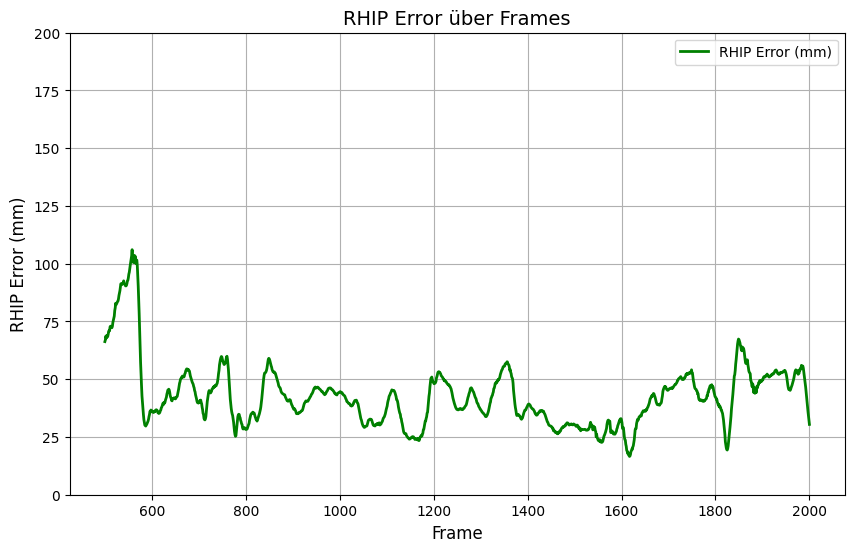

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Lade die Daten
file_path = r'E:\Datenerhebung MA\MPJPE\Poseformer\Cam1\AEN262_09_ebs_MPJPE.csv'
data = pd.read_csv(file_path)

# Plot der "RHIP Error (mm)"-Spalte
plt.figure(figsize=(10, 6))
plt.plot(data['Frame'], data['RHIP Error (mm)'], label='RHIP Error (mm)', linewidth=2, color='green')
plt.title('RHIP Error über Frames', fontsize=14)
plt.xlabel('Frame', fontsize=12)
plt.ylabel('RHIP Error (mm)', fontsize=12)
plt.ylim(0, 200)
plt.grid(True)
plt.legend()
plt.show()
